In [1]:
import json
import uuid
from functools import reduce

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML

from jinja2 import Template

# Smartsheet
import sys
from collections import defaultdict, namedtuple
import smartsheet

# Define a quartely time schema
years_in_model = 3
quarters = range(1, years_in_model * 4 + 1)
quarter_labels = ['Q' + str(q) for q in quarters]
#### STEP 1:  Calculate simple non-discounted cost-benefit cash flows for a single quarter with a delay ramp, and max
#### STEP 2:  Use those cash flows to find a discounted cash flow for each project using Net Present Value (NPV)
#### STEP 3:  Assemble the net present value of estimated future cash flows across projects in the portfolio
#### STEP 4:  Show a composite overall return, and let the user change paramaters, risk levels, timing, etc. to optimize and plan

In [14]:
class CashFlow():
    def __init__(self, delay_qtrs, is_cost, max_amt, scale_up_qtrs, function, name='', flow_id=uuid.uuid4(), tot_qtrs=12):
        if scale_up_qtrs < 2: 
            raise Exception('the total number of quarters must be at least one')

        self.id = flow_id
        self.is_cost = is_cost
        self.function = function # Will interpret an instance according to this setting
        self.delay_qtrs = delay_qtrs
        self.name = name
        self.max_amt = max_amt
        self.scale_up_qtrs = scale_up_qtrs
        self.tot_qtrs = tot_qtrs
        
    def _sigmoid(self, x):
        """
        We define y at 95% max at end of delay and scale up period 
        y = .95L = L / (1 + e^-k(x_end - x_naught)) # https://en.wikipedia.org/wiki/Logistic_function
        For us, this means the scaling factor (k) is
        k = ln(1/.95 - 1)/((delay_qtrs + scale_up_qtrs/2) - (delay_qtrs + scale_up_qtrs))
        """
        # 1 / 2 scale_up_qtrs to place x_naught at vertical of sigmoid from after delay
        x_naught = self.delay_qtrs + self.scale_up_qtrs / 2
        x_end = self.delay_qtrs + self.scale_up_qtrs
        k = math.log(1/.95 - 1) / (x_naught - x_end)
        return self.max_amt / (1 + math.exp(-k * (x - x_naught)))
    
    def _linear(self, x):
        """y = mx + b. Units in amount (returned value) per quarter (x)"""
        m = self.max_amt / self.scale_up_qtrs
        b = -m * self.delay_qtrs
        return min(m * x + b, self.max_amt) # Never return more than max
    
    def _single(self, x):
        if x == self.delay_qtrs:
            return self.max_amt
        else:
            return 0
    
    def _step(self, x):
        return self.max_amt
    
    def _calculate_qtr(self, f):
        values = []
        for quarter_n in range(0, self.tot_qtrs):
            if quarter_n < self.delay_qtrs:
                values.append(0)
            else:
                multiplier = -1 if self.is_cost else 1
                # TODO: multiply by -1 here if it is a COST we are considering
                values.append(multiplier * f(quarter_n))
        return values

    def quick_view(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(range(self.tot_qtrs), self.sigmoid_qtr, label='sigmoid')
        ax.plot(range(self.tot_qtrs), self.linear_qtr, label='linear')
        ax.plot(range(self.tot_qtrs), self.step_qtr, label='step')
        ax.scatter(range(self.tot_qtrs), self.single_qtr, label='single')
        ax.legend(loc='upper left')
        ax.grid(True)
    
    @property
    def qtr(self):
        """calculates quarter for instance based on set function type"""
        return self._calculate_qtr(getattr(self, f'_{self.function.lower()}'))
    
    @property
    def sigmoid_qtr(self):
        return self._calculate_qtr(self._sigmoid)
    
    @property
    def linear_qtr(self):
        return self._calculate_qtr(self._linear)
    
    @property
    def step_qtr(self):
        return self._calculate_qtr(self._step)
    
    @property
    def single_qtr(self):
        return self._calculate_qtr(self._single)
    
    def to_json(self):
        return {
            "flow_id": str(self.id),
            "function": self.function,
            "delay_qtrs": self.delay_qtrs,
            "is_cost": self.is_cost,
            "name": self.name,
            "max_amt": self.max_amt,
            "scale_up_qtrs": self.scale_up_qtrs,
            "tot_qtrs": self.tot_qtrs,
        }


SIGMOID
0.00	0.00	0.00	0.25	0.54	1.10	1.98	3.02	3.90	4.46	4.75	4.89

LINEAR
0.00	0.00	0.00	0.00	0.71	1.43	2.14	2.86	3.57	4.29	5.00	5.00

SINGLE
0.00	0.00	0.00	5.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00

STEP
0.00	0.00	0.00	5.00	5.00	5.00	5.00	5.00	5.00	5.00	5.00	5.00


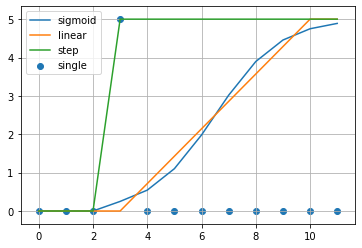

In [15]:
def pp(name, lst):
    print(f"\n{name}")
    print('\t'.join(["{0:.2f}".format(i) for i in lst]))

cf = CashFlow(name='test', delay_qtrs = 3, max_amt = 5, scale_up_qtrs = 7, function='linear', is_cost=False)

pp('SIGMOID', cf.sigmoid_qtr)
pp('LINEAR', cf.linear_qtr)
pp('SINGLE', cf.single_qtr)
pp('STEP', cf.step_qtr)

cf.quick_view()

In [16]:
class Styles():
    CONTAINER = "padding: 0; display: flex;"
    PARAM = "flex: 1; list-style-type: none; text-align: center;"
    VALUE = "display: block; text-align: center;"
    
class Project():
    """Add cash flows to a project"""
    def __init__(self, name):
        self.cash_flows = []
        self.name = name  # define before attempting to load from disk
        self._load_from_disk()  # important to load before generating cash_flow_list
        self.cash_flow_list = widgets.VBox(children=[self.widgetize_cf(cf) for cf in self.cash_flows])

        self.is_cost = widgets.Checkbox(value=False, description='Check if cash flow is a cost')
        self.cf_name = widgets.Text(placeholder='Name or description', description='Name')
        self.func_type = widgets.ToggleButtons(options=['linear', 'sigmoid', 'single', 'step'], description='Form')
        self.ben_delay = widgets.IntSlider(min=0, max=8, step=1, value=2, description='Ben. Delay', continuous_update=False)
        self.ben_ramp = widgets.FloatSlider(min=2, max=12, step=0.5, value=4, description='Ben. Ramp', continuous_update=False)
        self.ben_max = widgets.FloatSlider(min=0, max=30, step=0.5, value=4, description='Ben. Max', continuous_update=False)
        
        create_btn = widgets.Button(description="Add Cash Flow")
        create_btn.on_click(self.on_create_click)

        self.graph_out = widgets.Output()
        self.update_graphs()
        
        
        
        menu = widgets.VBox(
            children=[self.cf_name, self.is_cost, self.func_type, self.ben_delay, self.ben_ramp,
                      self.ben_max, create_btn, self.graph_out],
            layout=widgets.Layout(overflow="hidden")
        )
        
        self.app = widgets.AppLayout(left_sidebar=menu, right_sidebar=self.cash_flow_list)
        display(self.app)

    def _on_delete_click_factory(self, model):
        """A partially applied function that accepts a model,
        and returns a new function a button can click with context
        to a specific model"""

        def on_delete_click(button):
            index = None
            for i, cash_flow in enumerate(self.cash_flows):
                if cash_flow.id == model.id:
                    index = i
                    break

            if index is not None:
                self.cash_flows.pop(index)
                self.update_cash_flows()
                self.graph_out.clear_output(wait=True)
                self.update_graphs()

        return on_delete_click
    
    def _save_to_disk(self):
        with open(self.filename, 'w') as outfile:
            json.dump([cf.to_json() for cf in self.cash_flows], outfile)
    
    def _load_from_disk(self):
        try:
            with open(self.filename) as json_file:
                data = json.load(json_file)
                if not isinstance(data, list):
                    raise Exception(f'delete the file: {self.filename}, data is bad. It will regenerate.')
                for d in data:
                    cf = CashFlow(**d)
                    self.cash_flows.append(cf)
        except FileNotFoundError:
            print('could not find file, creating new')
    
    @property
    def filename(self):
        slug = self.name.lower().replace(' ', '-')
        return f'./data/{slug}-data.json'
        
    def update_cash_flows(self):
        self.cash_flow_list.children = [self.widgetize_cf(cf) for cf in self.cash_flows]
        self._save_to_disk()

    def on_create_click(self, event):
        f = CashFlow(
            delay_qtrs = self.ben_delay.value, 
            max_amt = self.ben_max.value,
            scale_up_qtrs = self.ben_ramp.value,
            function = self.func_type.value,
            name = self.cf_name.value,
            is_cost = self.is_cost.value
        )
        self.cash_flows.append(f)
        self.update_cash_flows()
        self.update_graphs()

    def widgetize_cf(self, model):
        html = f"""
        <h4 style="text-align: center">{model.name}</h1>
        <ul style="{Styles.CONTAINER}">
            <li style="{Styles.PARAM}">Function <strong style="{Styles.VALUE}">{model.function}</strong></li>
            <li style="{Styles.PARAM}">Is Cost <strong style="{Styles.VALUE}">{model.is_cost}</strong></li>
            <li style="{Styles.PARAM}">delay quarters <strong style="{Styles.VALUE}">{model.delay_qtrs}</strong></li>
            <li style="{Styles.PARAM}">max amount <strong style="{Styles.VALUE}">{model.max_amt}</strong></li>
            <li style="{Styles.PARAM}">scale time <strong style="{Styles.VALUE}">{model.scale_up_qtrs}</strong></li>
        </ul>
        """
        html = widgets.HTML(
            value=html,
            layout=widgets.Layout(width='100%')
        )
        delete_button = widgets.Button(
            description='delete',
            button_style='danger',
            layout=widgets.Layout(margin='5px'),
        )
        delete_button.on_click(self._on_delete_click_factory(model))
        return widgets.VBox(
            children=[html, delete_button],
            layout=widgets.Layout(
                border='1px solid',
                margin='4px',
                justify_content='center',
                align_items='center',
                display='flex'
            )
        )
    
    def update_graphs(self):
        self.graph_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return

        def trim_axs(axs, N):
            axs = axs.flat
            for ax in axs[N:]:
                ax.remove()
            return axs[:N]

        def get_min_max(flows):
            values = reduce(list.__add__, [flow.qtr for flow in flows])
            return min(0, min(values)), max(values)
        
        # capture stdout of matplotlib to output catching context graph_out as widget to include
        with self.graph_out:
            cols = 3
            rows = len(self.cash_flows) // cols + 1
            figsize = (10, 8)
            fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
            axs = trim_axs(axs, len(self.cash_flows))
            ymin, ymax = get_min_max(self.cash_flows)
            for ax, cf in zip(axs, self.cash_flows):
                ax.set_title(cf.name)
                ax.set_ylim([ymin,ymax])
                ax.grid(True)
                ax.xaxis.set_ticks(range(1, 13))
                ax.plot(range(12), cf.qtr)

            plt.show(fig)


# Batch Performance

In [17]:
# batch_performance = Project('batch_performance')

# R2K

In [18]:
# r2k = Project('r2k')

# Load in Data from SmartSheet
Load in projects and all of their cashflows. This will manifest as a dictionary of project keys, with the values being a list of respective cash flows. From this map, the projects and their corresponding cash flows will be built in a for loop.

In [19]:
access_token = 'u1zwu2cf2708fdfuy6y46ttwx3'
sheet_id = 3317327430215556
smartsheet
ss = smartsheet.Smartsheet(access_token)
sheet = ss.Sheets.get_sheet(sheet_id)

In [34]:
# Simple named tuple to organize the index of a cell, and if it is required or not
#
# Parsing immediately, and with intent of what must be there prevents
# a slew of boundary type errors or runtime ones.
Cell = namedtuple('Cell', ['index', 'name', 'required'])


class Row():
    """Reusable Smartsheet class for parsing a row. To use, define a child class which contains
    class attributes with a namedtuple defining each cell that should be parsed. This child class will
    inherit from this one, and automatically load and process all defined attributes.
    It is also possible to define methods to override the value when necessary. For example, divide an
    annual value by four"""
    def __init__(self, row):
        self.sheet_row = row
        self.cells = row['cells']
        self.row_number = row['rowNumber']
        # essentially grab the class attributes
        self.cell_defs = [getattr(self, attr) for attr in dir(self) if 'CELL_' in attr]
        self._load_cells()

    def _load_cells(self):
        for cell_def in self.cell_defs:
            modifier = getattr(self, f'_{cell_def.name}', None) or self._identity
            unmodified = self._get_cell(cell_def)
            value = modifier(unmodified) if unmodified is not None else None
            setattr(self, cell_def.name, value)
        
    @staticmethod
    def _identity(x):
        return x
        
    def _get_cell(self, cell_descriptor):
        """Will try to grab the cell regardless, if it is required, an error will be logged"""
        try:
            if cell_descriptor.required:
                cell_value = self.cells[cell_descriptor.index]['value']
                return cell_value
            else:
                cell = self.cells[cell_descriptor.index]
                return cell.get('value', None)
        except:
            raise Exception(f'Failed to process Row <{self.row_number}>. Missing {cell_descriptor.name}')

    def to_json(self):
        cell_defs = [getattr(self, attr) for attr in dir(self) if 'CELL_' in attr]
        return { cd.name: getattr(self, cd.name) for cd in cell_defs}


class PortfolioSheetRow(Row):
    """All cells that are desired MUST have a class attribute defined where:
       "CELL_" is part of the name. The class will use those attributes to parse the row.
       
       Any methods defined with the same "name" as the attribute preceeded by an underscore
       will apploy that function to the attribute as a clean way to modify the value if necessary.
       """
    CELL_DESC = Cell(0, 'name', True)
    CELL_FTE = Cell(1, 'fte', False)
    CELL_FTE_UNALLOCATED = Cell(2, 'fte_unallocated', False)
    CELL_FTE_OTHER = Cell(3, 'fte_other', False)
    CELL_INCLUDE_IN_MODEL = Cell(4, 'include_in_model', True)
    CELL_PROJECT_CODE = Cell(5, 'project_code', True)
    CELL_REV = Cell(6, 'annual_revenue', False)
    CELL_GP = Cell(7, 'gross_profit_perc', False)
    CELL_ATTRIB = Cell(8, 'attribution_perc', False)
    CELL_COST_OR_BENEFIT = Cell(9, 'is_cost', True)
    CELL_CF_PROFILE = Cell(10, 'function', True)
    CELL_DISCOUNT_RATE = Cell(11, 'discount_rate', True)
    CELL_ANNUALIZED_START_VALUE = Cell(12, 'start_value', False)
    CELL_DELAY_QUARTERS = Cell(13, 'delay_qtrs', True)
    CELL_ANNUALIZED_MAX_VALUE = Cell(14, 'max_amt', True)
    CELL_RAMP_TIME = Cell(15, 'scale_up_qtrs', True)
    CELL_COMMENTS = Cell(16, 'comments', False)
    
    def __init__(self, row):
        # Extra logic is used to decide if row should be processed at all
        # This allows us to "fail fast" when a row we want to parse doesn't have the data we want
        cells = row['cells']
        include = cells[PortfolioSheetRow.CELL_INCLUDE_IN_MODEL.index].get('value', None)
        self.project_code = cells[PortfolioSheetRow.CELL_PROJECT_CODE.index].get('value', None)
        self.include_in_model = True if include == "Yes" else False
        
        if self.include_in_model and self.project_code:
            super().__init__(row)
        
    @staticmethod
    def _profile_type(val):
        text = val.lower()
        if text == 'continuous' or text == 'step':
            return 'step'
        elif text == 'single pmt.':
            return 'single'
        elif text == 'logistic':
            return 'sigmoid'
        elif text == 'linear':
            return 'linear'
        else:
            raise Exception(f'Unknown profile type: {val}')
    
    @staticmethod
    def _include_in_model(val):
        return val.lower() == 'yes'

    @staticmethod
    def _is_cost(val):
        return val.lower() == 'cost'
    
    

# Script for quick verification testing
# row_num = 21
# row = sheet.rows[row_num - 1]
# r = PortfolioSheetRow(row.to_dict())
# blacklisted = ['__', 'cell_defs', 'CELL', 'cells', 'sheet_row', '_get_cell', '_identity', '_profile_type', 'row_number', '_include']
# for a in dir(r):
#     if any([s in a for s in blacklisted]):
#         continue
#     print(a + '\t\t\t' + str(getattr(r, a)))

In [35]:
# r.to_json()

In [36]:
# Allow for easy targeting of rows, here [20 - 70]
SHEET_ROW_START = 20
SHEET_ROW_END = 70


def sheet_row_to_cf(row):
    return CashFlow(
        delay_qtrs = row.delay_qtrs, 
        max_amt = row.max_amt,
        scale_up_qtrs = row.scale_up_qtrs,
        function = row.function,
        name = row.name,
        is_cost = row.is_cost
    )

project_map = defaultdict(list)
for index, sheet_row in enumerate(sheet.rows):
    if index < SHEET_ROW_START or index > SHEET_ROW_END:
        continue

    row = PortfolioSheetRow(sheet_row.to_dict())
    if row.project_code and row.include_in_model:
        project_map[row.project_code].append(sheet_row_to_cf(row))

project_map

defaultdict(list,
            {'FS': [<__main__.CashFlow at 0x119292a90>,
             'BP': [<__main__.CashFlow at 0x11979bd50>,
             'PV': [<__main__.CashFlow at 0x119046350>,
              <__main__.CashFlow at 0x119c08710>]})

In [29]:
projects = [Project('batch_performance'), Project('r2k')]

could not find file, creating new


AppLayout(children=(VBox(children=(Text(value='', description='Name', placeholder='Name or description'), Chec…

could not find file, creating new


AppLayout(children=(VBox(children=(Text(value='', description='Name', placeholder='Name or description'), Chec…

In [30]:
# projects = [batch_performance, r2k]

In [31]:
def combine_flows(flows):
    qtr_values = map(lambda cf: cf.qtr, flows)
    aggregated_values = [sum(values) for values in zip(*qtr_values)]
    return aggregated_values

combine_flows(r2k.cash_flows)

NameError: name 'r2k' is not defined

## Step 1

In [ ]:
### STEP 1 START ###
# For logistic growth we can define a sigmoid function
# Sigmoid function, f(-6) = 0; f(0) = 0.5;  f(6) = 1.0;
# Sigmoid / logistic growth would be a common cash flow profile
# Future options to add would be 'step function,' 'linear growth,' 'exponential growth,' etc.
def sigmoid(x):
    shift = 3 # 5% of max value is "zero"
    return 1 / (1 + math.exp(-(x - shift)))

# Define a quarterly implementation of logistic growth / sigmoid based on delay in years, max $ amount, and the time to ramp up
# All values in quarters except the 'max_amt' which is in dollars($M USD)
# max_amt is the 'carrying capacity' of the sigmoid function, usually known as 'k' in academic formulas
def sigmoid_qtr(delay_qtrs, max_amt, scale_up_qtrs, tot_qtrs=12):
    mylist = []
    if scale_up_qtrs < 2: 
        print('the total number of quarters must be at least one')
    # -3 corresponds to 5% of max value, and 3 corresponds to 95% of max value, going to use those values to define function.
    sigmoid_start = -3
    sigmoid_last = 3
    quarterly_x = (sigmoid_last - sigmoid_start) / scale_up_qtrs
    # print(f'quarterly_x = {quarterly_x}')
    for i in range(0, tot_qtrs):
        if i < delay_qtrs:
            mylist.append(0)
        else: 
            x_val = sigmoid_start + quarterly_x*(i - delay_qtrs)
            mylist.append(max_amt * sigmoid(x_val))
    return mylist

# Let's try a test case with some benefits with a max of $5M that start in 3 quarters, fully realized in 6 quarters
delay_qtrs = 3
max_amt = 5
scale_up_qtrs = 7
test = sigmoid_qtr(delay_qtrs, max_amt, scale_up_qtrs)

# Red line is the number of delay quarters, when the function kicks in
# Blue line is the end of scale up when you are getting close to max benefits
def plotter(ben_vals, delay_qtrs, scale_up_qtrs):
    labels = np.arange(1, len(test)+1)
    plt.bar(labels, ben_vals)
    plt.axvline(x=delay_qtrs, color = 'r')
    plt.title('Scale up of Cash Flows')
    plt.axvline(x=(delay_qtrs + scale_up_qtrs), color = 'b')
    plt.show;
# plotter(test, delay_qtrs, scale_up_qtrs)

# This should print both costs and benefits
def dual_plotter(costs, bennies):

    # set width of bar
    barWidth = 0.25

    # calculate the net benefit for the quarter
    net = [x1 - x2 for (x1, x2) in zip(bennies, costs)]
    
    # set height of bar
    bars1 = costs
    bars2 = bennies
    bars3 = net

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='cost')
    plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='bennies')
    plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='net')

    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], quarter_labels)

    # Create legend & Show graphic
    plt.legend()
    plt.show();


In [ ]:
def f(x, y, z, a, b, c):
    benefits = sigmoid_qtr(x, y, z)
    costs = sigmoid_qtr(a, b, c)
    
    # To plot a single cash flow:
    # plotter(benefits, x, y, costs)
    
    # To plot both costs and benefits together:
    dual_plotter(benefits, costs)


# Need to get this working for negative numbers.  Cash flow profiles for costs / investments will be negative numbers.
# But maybe we can just calculate as positive, and then take the diff for net cash flow and put into a dataframe
# Just need to review math of the above functions to make sure it works for negative numbers.
# Turning off continuous update here :) 
benefits_delay = widgets.IntSlider(min=0, max=8, step=1, value=2, description='Ben. Delay', continuous_update=False)
benefits_ramp = widgets.FloatSlider(min=2, max=12, step=0.5, value=4, description='Ben. Ramp', continuous_update=False)
benefits_max = widgets.FloatSlider(min=0, max=30, step=0.5, value=4, description='Ben. Max', continuous_update=False)

# We should probably include a component eventually where costs are a function of benefits, but for now, let's model them independently.
cost_delay = widgets.FloatSlider(min=0, max=12, step=0.5, value=4, description='Cost Delay', continuous_update=False)
cost_ramp = widgets.FloatSlider(min=0, max=12, step=0.5, value=4, description='Cost Ramp', continuous_update=False)
cost_max = widgets.FloatSlider(min=0, max=30, step=0.5, value=4, description='Cost Max', continuous_update=False)

interact(f, x=benefits_delay, y=benefits_ramp, z=benefits_max, a=cost_delay, b=cost_ramp, c=cost_max);


##### There is something weird in how the sigmoid_qtr function is returning values.  
##### Example, if you set the 'cost max' or 'benefit max' really high, it seems to change the ramp-up time, 
##### and the max value in the slider doesn't match the max value in the plot.

# Step 2

In [ ]:
## Discounted Cash Flows can use this formula, once we find the : 
example_net_cashflow = [-100, 19, 49, 58, 200]

# Using a shortcut here dividing by four to calculate quarterly interest from annual discount rate of 25%
# There is a better way to do the conversion, but example below:
npv_net =  np.npv(0.35/4,[-100, 19, 49, 58, 200, 100]) 
print("Net Present Value(npv) : ", npv_net) 

# we could also calculate an IRR using the IRR module from python, but NPV is fine for now.

#### STEP 2 END
#### STEP 3 START

In [ ]:
## Start building out a dataframe for project financial parameters and 12 months of cash flows
## Cash flows can be populated with the growth curves above

row_titles = ['visibility', 'growth', 'gamechangers']
column_titles = ['internal_fte', 'external_spend', 'max_benefit', 'profile', 'discount_rate']
d = pd.DataFrame(0, index=row_titles, columns=column_titles)

In [ ]:
quarter_labels

In [ ]:
years_in_model = 3
quarters = (list(range(years_in_model * 4)))
quarters = [q + 1 for q in quarters]

In [ ]:
a = np.zeros((len(row_titles),len(quarters)))
cost_benefit = pd.DataFrame(a, index = row_titles, columns=quarters)

In [ ]:
# so once we estimate the benefits and the costs, we can populate the quarterly cash flows into a dataframe
# The three major categories of projects are visibility (R2K, etc.), growth (batch perf., etc.), gamechangers (proteinview, etc.)
comb = pd.concat([d, cost_benefit], axis=1, sort=False)
comb

# Once we phase in cash flows, we can discount them back with an Net Present Value (NPV) using the discount rate.

In [ ]:
### HMM... how to iterate over the rows to replace the cash flows in the data frame for a given investment area.
# adder = 1
# for key, value in cost_benefit.iteritems(): 
#     value = value + adder
#     adder += 1
#     print(value) 
#     print() 

In [ ]:
?zip